In [67]:
'''
Zé Fonseca

24/02/16

MCMC for general cosmological datasets.
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
#from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
import sys

%matplotlib inline

## Data info

* N_SNeIa=10, gaussian distribution ~${\cal N}(0.5,0.1)$;
* errors: $\sigma_\mu=0.01$, $\sigma_z=0.01(1+z)$;


In [6]:
#cosmological functions
#general functions

def invH(z,OM,w):
    return (OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))**(-.5)

c=2.99792e5

def mu(z,OM,H0,w):
    if type(z)==float or type(z)==int:
        return 5*np.log10((1+z)/H0*c*quad(invH,0,z,args=(OM,w))[0])+25
    else:
        dl=[]
        for i in range(len(z)):
            dl.append(quad(invH,0,z[i],args=(OM,w))[0])
        return 5*np.log10(np.array(dl)*(1+z)*c/H0)+25

#class fake data with all the cases.

class fkd:
    def __init__(self,name,filename,OM=0.31,H0=67.74,w=-1,sig_mu=0.01,wrong_data=True):
        #parameters used
        self.OM=OM
        self.H0=H0
        self.w=w
        self.dataset=name
        
        dados=np.loadtxt(filename)
        self.z=dados[:,0]
        self.mu_o=dados[:,1]
        self.sig_mu=sig_mu
        if wrong_data==True:
            self.z_real=dados[:,2]
        

In [7]:
#initiate data
fd1=fkd('cosmoSNe_1','../general_datasets/data_cosmoSNe_1.txt')
fd2=fkd('cosmoSNe_2','../general_datasets/data_cosmoSNe_2.txt')
fd3=fkd('cosmoSNe_3','../general_datasets/data_cosmoSNe_3.txt')
fd4=fkd('cosmoSNe_4','../general_datasets/data_cosmoSNe_4.txt')
fd5=fkd('cosmoSNe_5','../general_datasets/data_cosmoSNe_5.txt')


# Part 2

## MCMC to data with errors in z

Notes: when adding errors in MCMC we need 3 different error adding. Case 3 does not have mu errors increased in quadrature. 

In [8]:
# Functions

#MCMC priors
def prior_om(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0
    
def prior_w(x):
    if x>=-6 and x<=4:
        return 1
    else:
        return 0
    
def prior_H0(x):
    if x>=10 and x<=200:
        return 1
    else:
        return 0
    
def chi2(mu_o,mu_t,sigma2):
    return (mu_o-mu_t)**2/sigma2



In [9]:
def log_like_fixsig(data,om,H0,w):
    mu_t=mu(data.z,om,H0,w)
    return -chi2(data.mu_o,mu_t,data.sig_mu**2)/2

# Highly inneficient coding but I wanna keep track of everuthing

def dmudz(z,mu,OM,H0,w):
    return 5/np.log(10)*(1/(1+z)+(1+z)*c*invH(z,OM,w)/H0*10**(5-mu/5))


def log_like_analmarg(data,om,H0,w):
    m=dmudz(data.z,data.mu_o,om,H0,w)
    red_mu_o=data.mu_o-mu(data.z,om,H0,w)+data.z*m
    Cov=data.sig_mu**2*(0.1**2+(0.01*(1+data.z))**2)+(m*0.01*(1+data.z)*0.1)**2
    
    return -0.5*(((0.01*(data.z-0.5))**2+(0.1*(red_mu_o-m*data.z))**2+\
                 (0.01*(1+data.z)*(red_mu_o-m*0.5))**2)/Cov+Cov)

In [10]:
def MCMC_SNe(N,data,loglike_func=log_like_fixsig):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    log_like=np.zeros(N)
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    log_like[0]=sum(loglike_func(data,o_m[0],H0[0],w[0]))
    
    #dummy var for acceptance rate
    accept=1
    for i in range(N-1):
        accept+=1
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1]=log_like[i]
            accept-=1
            continue
        else:
            #compute new log_like
            log_like[i+1]=sum(loglike_func(data,o_m[i+1],H0[i+1],w[i+1]))
            #if priors not flat they need to be included after the exp. for now flat prior
            r=sp.exp(log_like[i+1]-log_like[i])
            #accept or not
            teste=np.random.rand()
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1]=log_like[i]
                accept-=1
                continue
            
                
        #really cool piece of code from Ethan
        inc100 = np.int64(i/(N)*100)
        inc50 = np.int64(i/(N)*50)
        sys.stdout.write('\r')
        sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
        sys.stdout.flush()
    
    acceptr=accept/N*100
    if loglike_func==log_like_analmarg:
        data.anlm_acceptr=acceptr
        data.anlm_chain_o_m=o_m
        data.anlm_chain_w=w
        data.anlm_chain_H0=H0
        data.anlm_log_like=log_like
    #if loglike_func==log_like_realz:
    #    data.rz_acceptr=acceptr
    #    data.rz_chain_o_m=o_m
    #    data.rz_chain_w=w
    #    data.rz_chain_H0=H0
    #    data.rz_log_like=log_like
    else:
        data.acceptr=acceptr
        data.chain_o_m=o_m
        data.chain_w=w
        data.chain_H0=H0
        data.log_like=log_like
        data.acceptr=acceptr    

## Make plots

In [ ]:
def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

def plot_contour_hist_1(data1,burn_tail=500,thining=1,nb=10,loglike='normal'):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    
    if loglike=='normal':
        om=data1.chain_o_m[burn_tail::thining]
        w=data1.chain_w[burn_tail::thining]
        H0=data1.chain_H0[burn_tail::thining]
    if loglike=='unbias':
        om=data1.anlm_chain_o_m[burn_tail::thining]
        w=data1.anlm_chain_w[burn_tail::thining]
        H0=data1.anlm_chain_H0[burn_tail::thining]
    if loglike=='real_z':
        om=data1.rz_chain_o_m[burn_tail::thining]
        w=data1.rz_chain_w[burn_tail::thining]
        H0=data1.rz_chain_H0[burn_tail::thining]
    if loglike=='num_marg':
        om=data1.nmarg_chain_o_m[burn_tail::thining]
        w=data1.nmarg_chain_w[burn_tail::thining]
        H0=data1.nmarg_chain_H0[burn_tail::thining]
    if loglike=='fithyper':
        om=data1.fithyper_chain_o_m[burn_tail::thining]
        w=data1.fithyper_chain_w[burn_tail::thining]
        H0=data1.fithyper_chain_H0[burn_tail::thining]
    
    
    Hist_mcmc, omedges,wedges = np.histogram2d(om,w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Neff=len(om)
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    #plt.plot(om_max,w_max,'rx',ms=10)
    
    bins_om=[round(x*0.025,3) for x in range(0,40)]
    bins_w=[round(x*0.05-6,3) for x in range(0,140)]
    bins_H=[x*0.25+50 for x in range(0,200)]

        
    om_min=np.amin(om)
    om_max=np.amax(om)
    
    w_min=np.amin(w)
    w_max=np.amax(w)
    
    H0_min=np.amin(H0)
    H0_max=np.amax(H0)
               
    axarr[0,0].hist(om,color='r',bins=bins_om,alpha=0.15)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    axarr[1,0].contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax])
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(H0,bins=bins_H,color='r',alpha=0.15)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    
    axarr[1,1].hist(w,bins=bins_w,color='r',alpha=0.15,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    axarr[1,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.show()
    
def plot_conv_mcmc(data1,burn_tail=0,thining=1,loglike='normal'):
    
    f, axarr = plt.subplots(3,1,figsize=(8,12))
    
    if loglike=='normal':
        om=data1.chain_o_m[burn_tail::thining]
        w=data1.chain_w[burn_tail::thining]
        H0=data1.chain_H0[burn_tail::thining]
    if loglike=='unbias':
        om=data1.anlm_chain_o_m[burn_tail::thining]
        w=data1.anlm_chain_w[burn_tail::thining]
        H0=data1.anlm_chain_H0[burn_tail::thining]
    if loglike=='real_z':
        om=data1.rz_chain_o_m[burn_tail::thining]
        w=data1.rz_chain_w[burn_tail::thining]
        H0=data1.rz_chain_H0[burn_tail::thining]
    if loglike=='num_marg':
        om=data1.nmarg_chain_o_m[burn_tail::thining]
        w=data1.nmarg_chain_w[burn_tail::thining]
        H0=data1.nmarg_chain_H0[burn_tail::thining]
        
    axarr[0].plot(om)
    axarr[0].set_ylim([np.amin(om),np.amax(om)])
    axarr[0].set_ylabel(r'$\Omega_M$')
    
    axarr[1].plot(w)
    axarr[1].set_ylim([np.amin(w),np.amax(w)])
    axarr[1].set_ylabel(r'$w$')
    
    axarr[2].plot(H0)
    axarr[2].set_ylim([np.amin(H0),np.amax(H0)])
    axarr[2].set_ylabel(r'$H_0$')
    
    plt.setp(axarr[0].get_xticklabels(), visible=False)
    plt.setp(axarr[1].get_xticklabels(), visible=False)
    
    plt.show()

# Run for dataset with normal likelihood

In [17]:
Nsteps=100000

In [17]:
MCMC_SNe(Nsteps,fd1,log_like_fixsig)
print('\n',fd1.acceptr)


[################################################# ]99%
 2.562


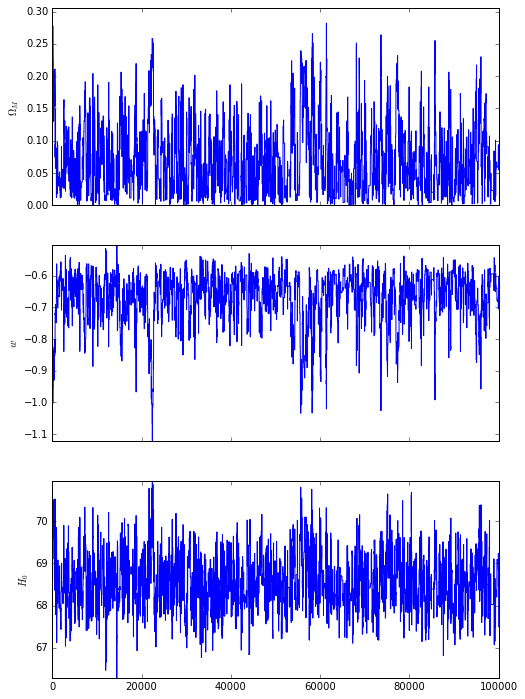

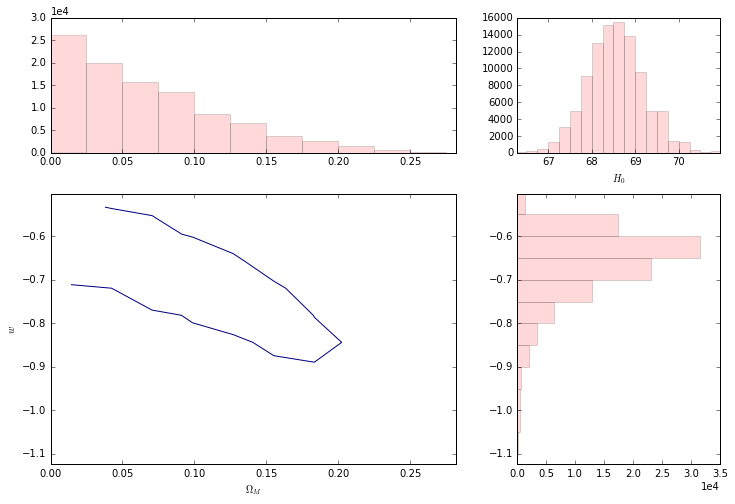

In [18]:
plot_conv_mcmc(fd1)
plot_contour_hist_1(fd1)


[################################################# ]99%
 2.62


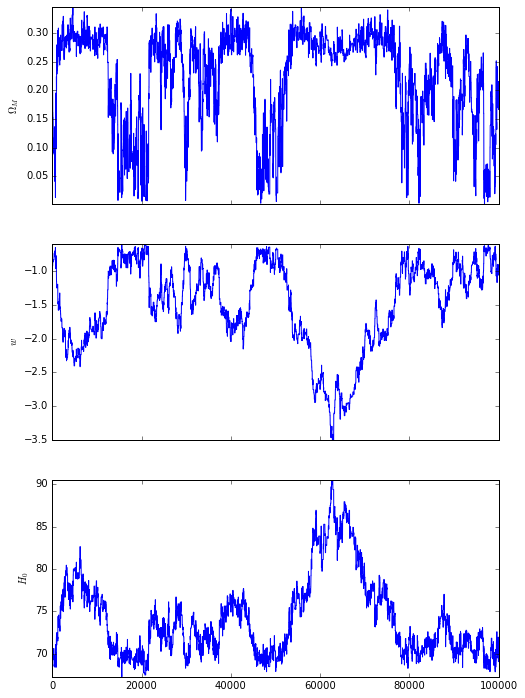

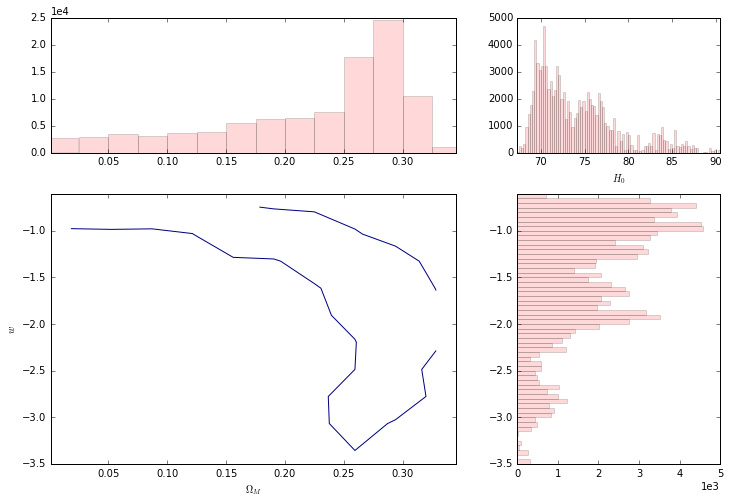

In [19]:
MCMC_SNe(Nsteps,fd2,log_like_fixsig)
print('\n',fd2.acceptr)
plot_conv_mcmc(fd2)
plot_contour_hist_1(fd2)
plt.show()

[################################################# ]99%
 5.229


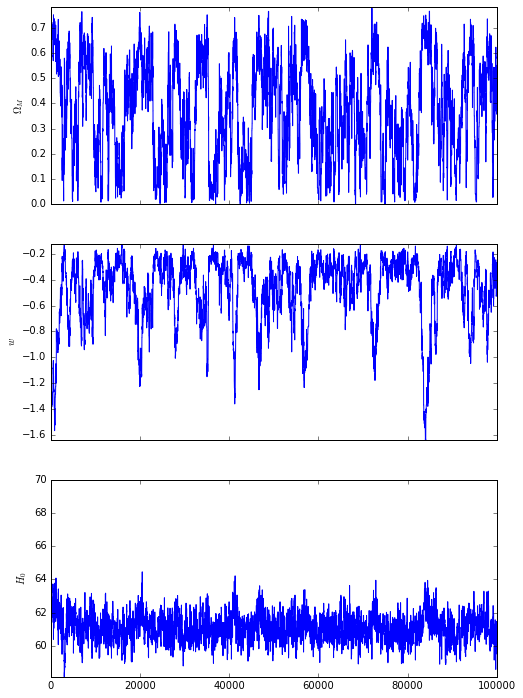

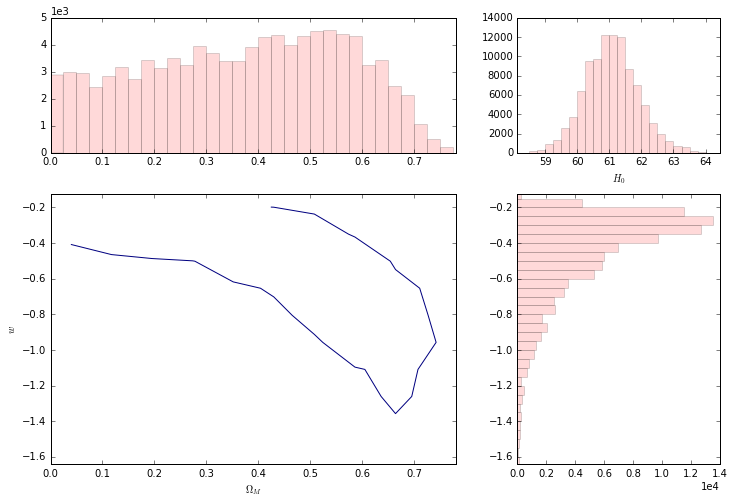

In [20]:
MCMC_SNe(Nsteps,fd3,log_like_fixsig)
print('\n',fd3.acceptr)
plot_conv_mcmc(fd3)
plot_contour_hist_1(fd3)
plt.show()

[                                                  ]0%

/Users/Ze/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: overflow encountered in exp


[################################################# ]99%
 2.682


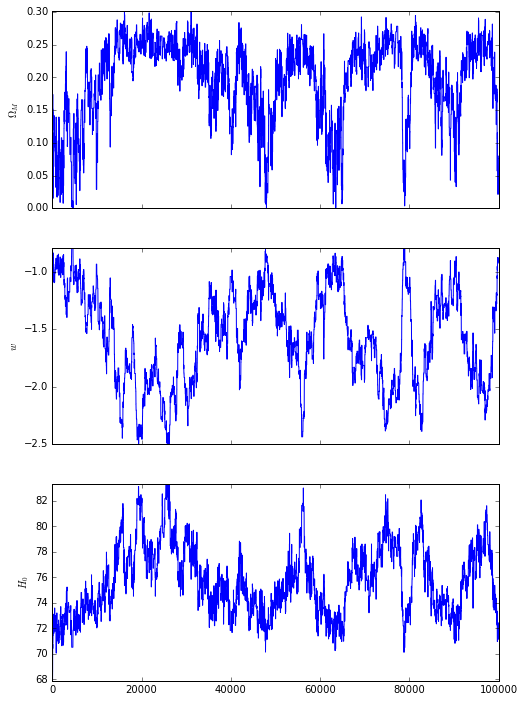

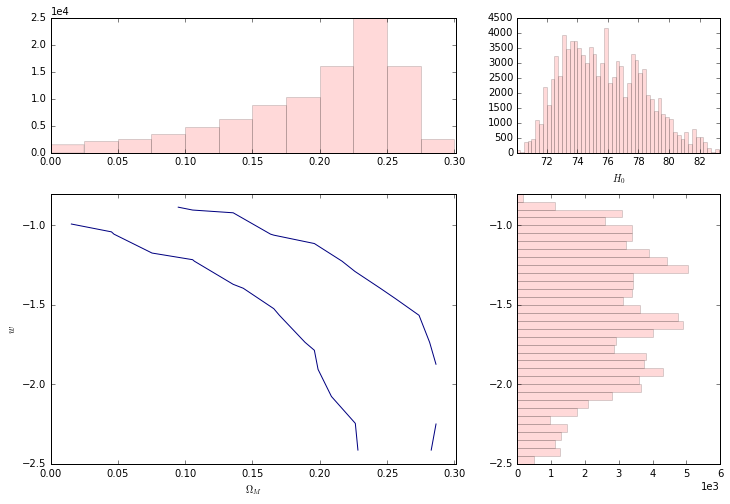

In [21]:
MCMC_SNe(Nsteps,fd4,log_like_fixsig)
print('\n',fd4.acceptr)
plot_conv_mcmc(fd4)
plot_contour_hist_1(fd4)
plt.show()

[################################################# ]99%
 2.5250000000000004


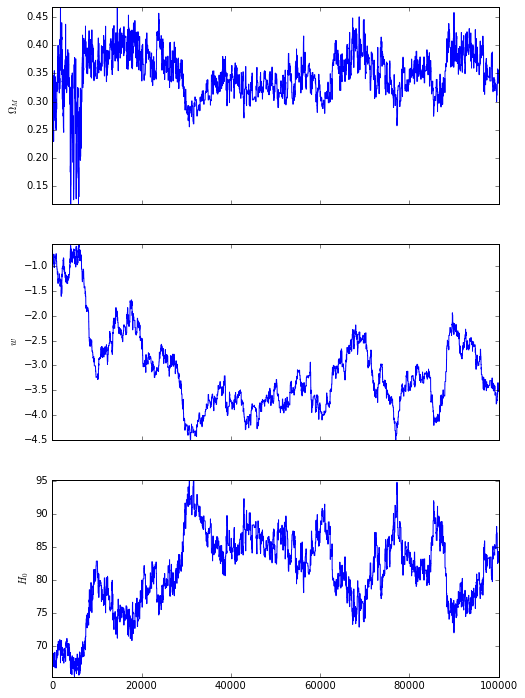

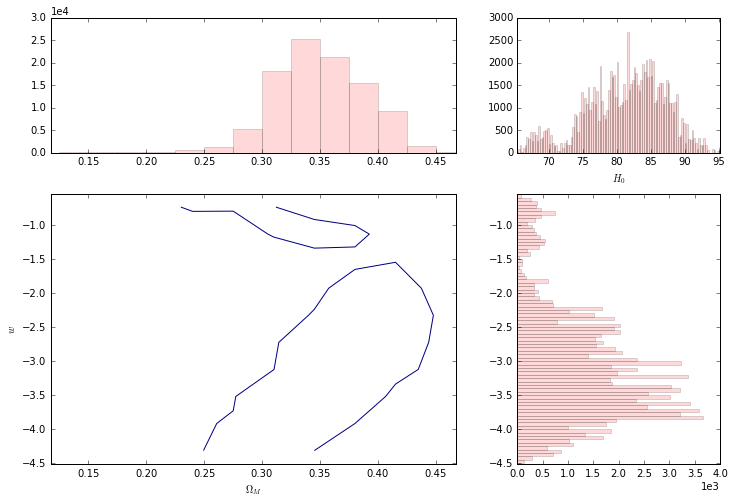

In [22]:
MCMC_SNe(Nsteps,fd5,log_like_fixsig)
print('\n',fd5.acceptr)
plot_conv_mcmc(fd5)
plot_contour_hist_1(fd5)
plt.show()

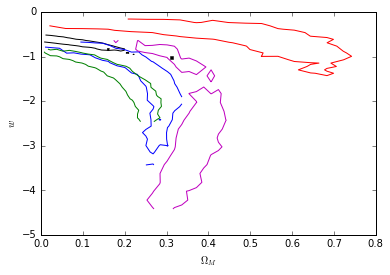

In [23]:
datas={'0':fd1,'1':fd2,'2':fd3,'3':fd4,'4':fd5}
nb=20
cor=['k','b','r','g','m']
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].chain_o_m,datas[str(i)].chain_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains.png')
plt.show()

In [24]:
def save_mcmc(data):
    np.savetxt('../general_datasets/chains_'+data.dataset+'.txt',np.c_[data.chain_o_m,data.chain_w,data.chain_H0,data.log_like],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3f'],header='\n'.join(["acceptance rate %.2f" %data.acceptr,\
                                                                           "Om   w   H0   log_like"]))

In [25]:
for i in range(5):
    save_mcmc(datas[str(i)])

## Include analytical marginalization

In [12]:
# Highly inneficient coding but I wanna keep track of everuthing

def dmudz(z,mu,OM,H0,w):
    return 5/np.log(10)*(1/(1+z)+(1+z)*c*invH(z,OM,w)/H0*10**(5-mu/5))


def log_like_analmarg(data,om,H0,w):
    m=dmudz(0.5,mu(0.5,om,H0,w),om,H0,w)
    red_mu_o=data.mu_o-mu(0.5,om,H0,w)+0.5*m
    Cov=data.sig_mu**2*(0.1**2+(0.01*(1+data.z))**2)+(m*0.01*(1+data.z)*0.1)**2
    
    return -0.5*(((0.01*(data.z-0.5))**2+(0.1*(red_mu_o-m*data.z))**2+\
                 (0.01*(1+data.z)*(red_mu_o-m*0.5))**2)/Cov+Cov)



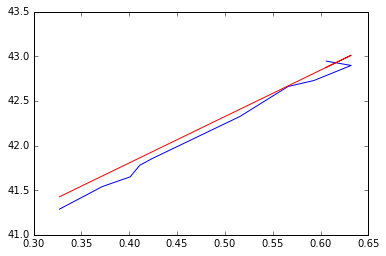

In [13]:
plt.plot(fd1.z,fd1.mu_o)
plt.plot(fd1.z,mu(0.5,0.31,67.74,-1)+dmudz(0.5,mu(0.5,0.31,67.74,-1),0.31,67.74,-1)*(fd1.z-0.5),'r')
plt.show()

[################################################# ]99%

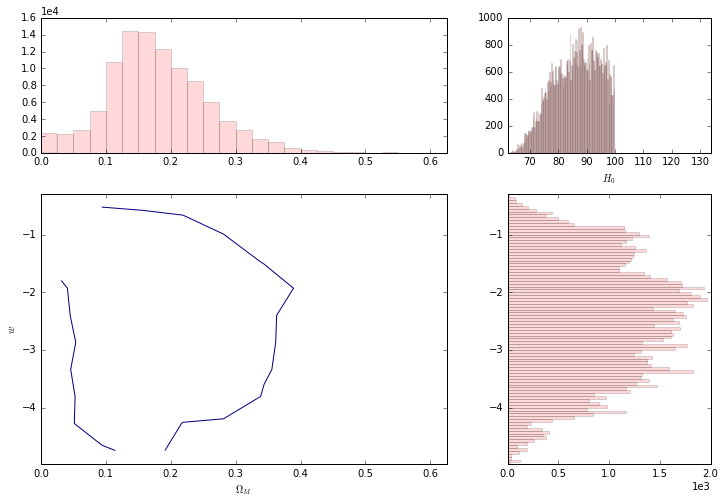

In [31]:
MCMC_SNe(Nsteps,fd1,loglike_func=log_like_analmarg)
plot_contour_hist_1(fd1,loglike='unbias')

In [33]:
MCMC_SNe(Nsteps,fd2,loglike_func=log_like_analmarg)
MCMC_SNe(Nsteps,fd3,loglike_func=log_like_analmarg)
MCMC_SNe(Nsteps,fd4,loglike_func=log_like_analmarg)
MCMC_SNe(Nsteps,fd5,loglike_func=log_like_analmarg)

[################################################# ]99%

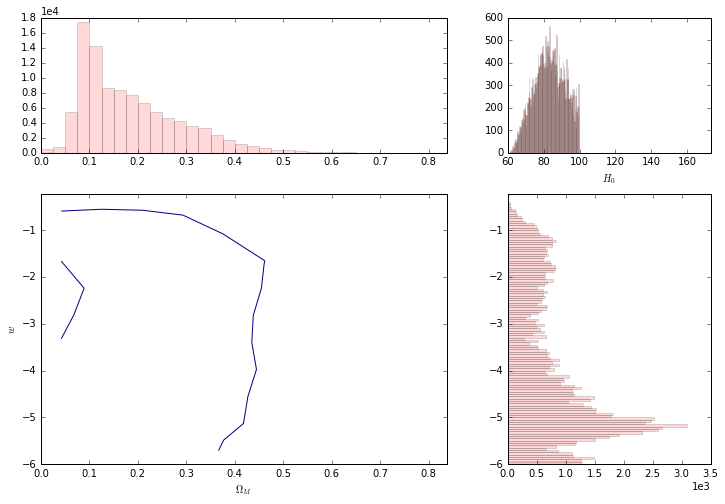

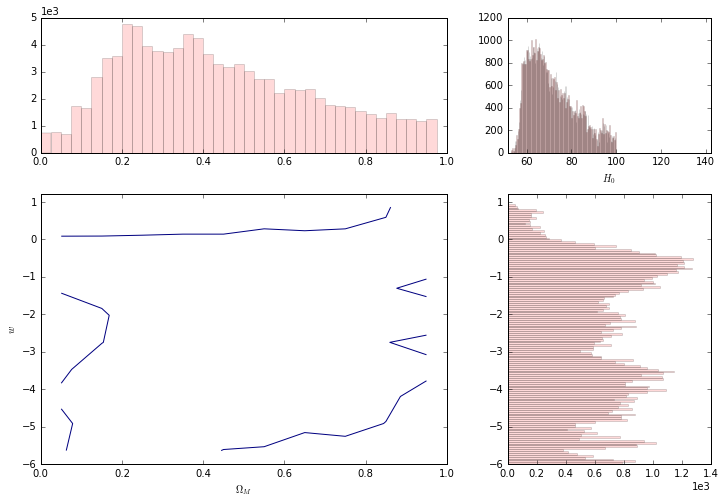

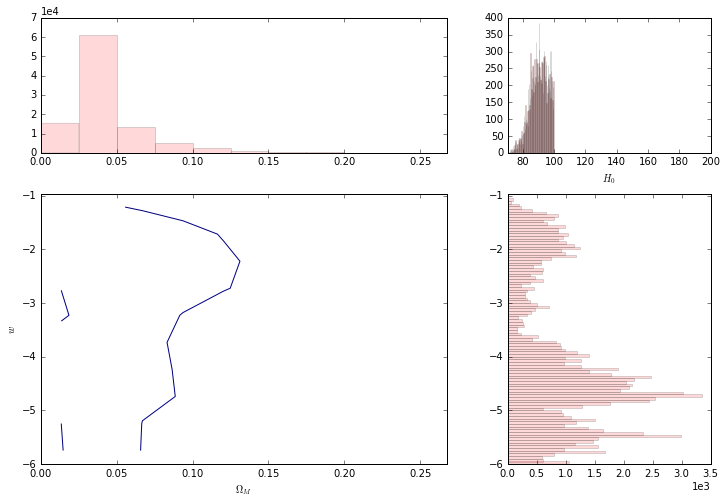

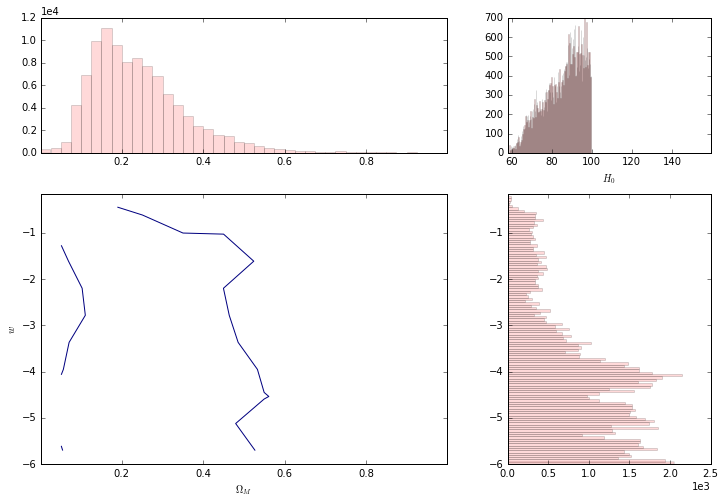

In [34]:
plot_contour_hist_1(fd2,loglike='unbias')
plot_contour_hist_1(fd3,loglike='unbias')
plot_contour_hist_1(fd4,loglike='unbias')
plot_contour_hist_1(fd5,loglike='unbias')

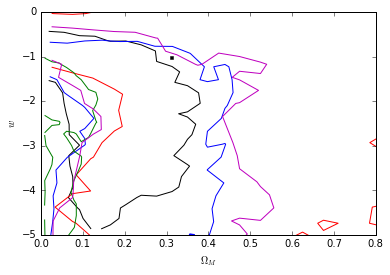

In [35]:
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].anlm_chain_o_m,datas[str(i)].anlm_chain_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains_analmarg.png')
plt.show()

## Fit for hyperparameters

Use the likelihood:
\begin{equation}
\log L=-\frac{1}{2} \sum_i \frac{1}{C}\left(\sigma_\mu^2(z_{\rm Obs,i}-\bar z)^2 +\sigma_p^2(\mu_{\rm Obs,i}-\mu(0.5,\Omega_m,H_0,w)+0.5m-mz_{\rm Obs,i})^2 +\sigma_z^2 ((\mu_{\rm Obs,i}-\mu(0.5,\Omega_m,H_0,w)+0.5m-m\bar z)^2\right)+C + constants
\end{equation}
\begin{equation}
C=\sigma_\mu^2(\sigma_p^2+\sigma_z^2) + m^2\sigma_p^2\sigma_z^2
\end{equation}

And we fit for $\vartheta=\Omega_m,H_0,w,\bar z,\sigma_p$.

In [93]:
def log_like_fithyper_analmarg(data,om,H0,w,zb,sp):
    m=dmudz(0.5,mu(0.5,om,H0,w),om,H0,w)
    red_mu_o=data.mu_o-mu(0.5,om,H0,w)+0.5*m
    Cov=data.sig_mu**2*(sp**2+(0.01*(1+data.z))**2)+(m*0.01*(1+data.z)*sp)**2
    
    return -0.5*(((data.sig_mu*(data.z-zb))**2+(sp*(red_mu_o-m*data.z))**2+\
                 (0.01*(1+data.z)*(red_mu_o-m*sp))**2)/Cov+Cov)

def MCMC_SNe_fithyper(N,data):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    zb=np.zeros(N)
    sp=np.zeros(N)
    log_like=np.zeros(N)
    

    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    zb[0]=0.4
    sp[0]=0.2
    log_like[0]=sum(log_like_fithyper_analmarg(data,o_m[0],H0[0],w[0],zb[0],sp[0]))
    
    #dummy var for acceptance rate
    accept=1
    for i in range(N-1):
        accept+=1
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        zb[i+1]=zb[i]+np.random.randn()*0.01
        sp[i+1]=sp[i]+np.random.randn()*0.01
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            zb[i+1]=zb[i]
            sp[i+1]=sp[i]
            
            log_like[i+1]=log_like[i]
            accept-=1
            continue
        else:
            #compute new log_like
            log_like[i+1]=sum(log_like_fithyper_analmarg(data,o_m[i+1],H0[i+1],w[i+1],zb[i+1],sp[i+1]))
            #if priors not flat they need to be included after the exp. for now flat prior
            r=np.exp(log_like[i+1]-log_like[i])
            #accept or not
            teste=np.random.rand()
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                zb[i+1]=zb[i]
                sp[i+1]=sp[i]
                log_like[i+1]=log_like[i]
                accept-=1
                continue
            
                
        #really cool piece of code from Ethan
        #inc100 = np.int64(i/(N)*100)
        #inc50 = np.int64(i/(N)*50)
        #sys.stdout.write('\r')
        #sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
        #sys.stdout.flush()
    
    acceptr=accept/N*100
    data.fithyper_acceptr=acceptr
    data.fithyper_chain_o_m=o_m
    data.fithyper_chain_w=w
    data.fithyper_chain_H0=H0
    data.fithyper_chain_zb=zb
    data.fithyper_chain_sp=sp
    data.fithyper_log_like=log_like
    

In [86]:
MCMC_SNe_fithyper(Nsteps,fd1)
print(fd1.fithyper_acceptr)

[################################################# ]99%18.64


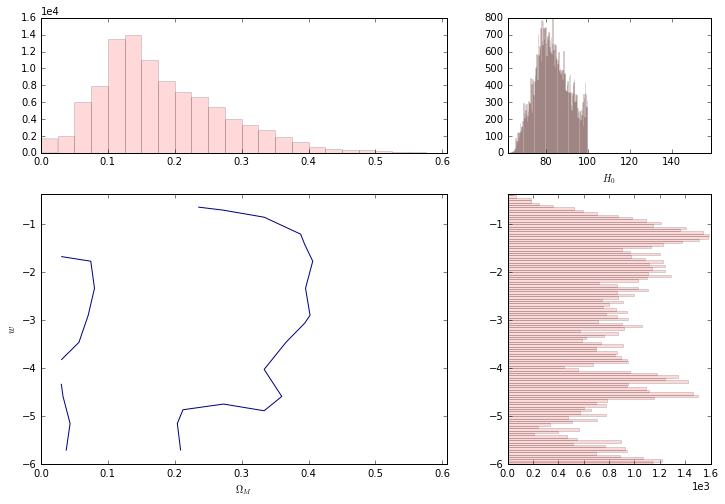

In [88]:
plot_contour_hist_1(fd1,loglike='fithyper')

In [ ]:
MCMC_SNe_fithyper(Nsteps,fd2)
MCMC_SNe_fithyper(Nsteps,fd3)

In [94]:
MCMC_SNe_fithyper(Nsteps,fd4)
MCMC_SNe_fithyper(Nsteps,fd5)

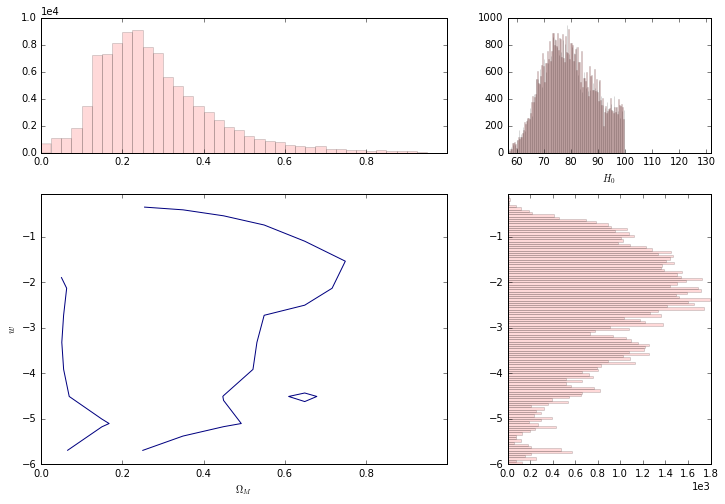

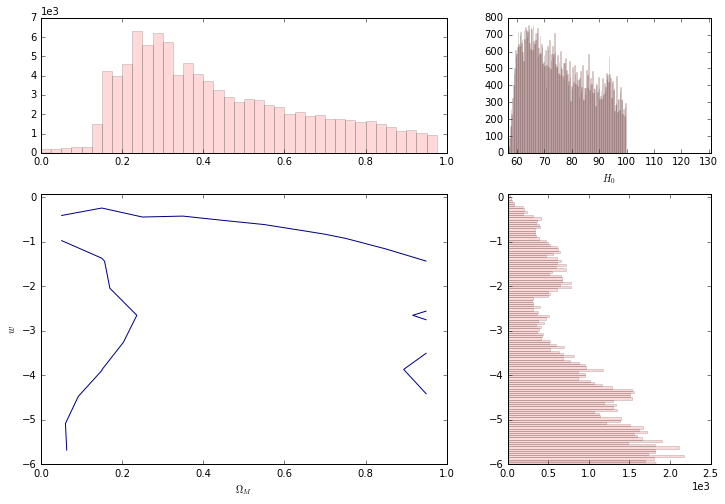

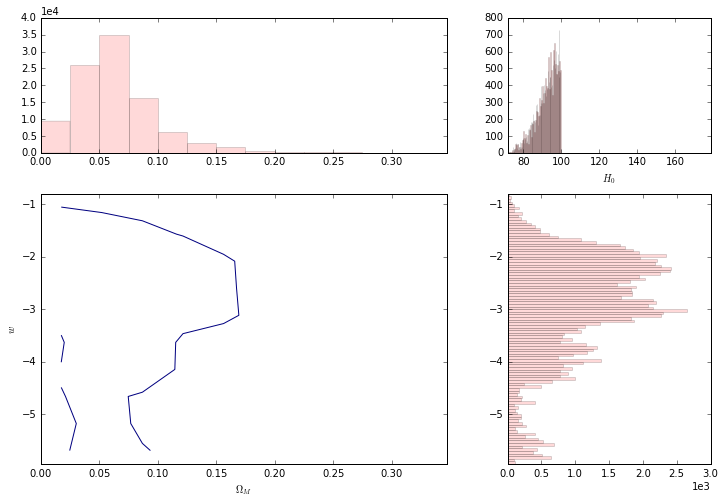

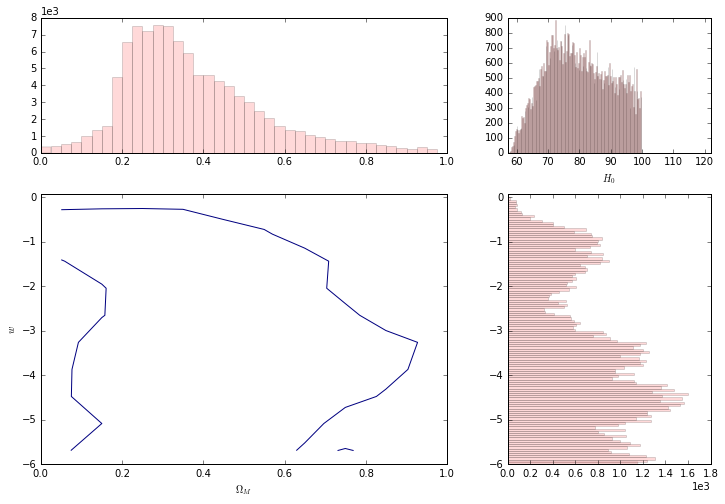

In [95]:
plot_contour_hist_1(fd2,loglike='fithyper')
plot_contour_hist_1(fd3,loglike='fithyper')
plot_contour_hist_1(fd4,loglike='fithyper')
plot_contour_hist_1(fd5,loglike='fithyper')

(array([  2678.,   4582.,   9588.,  15164.,  21308.,   7388.,  15312.,
         12331.,   5930.,   5719.]),
 array([ 0.06369301,  0.21907384,  0.37445467,  0.52983549,  0.68521632,
         0.84059714,  0.99597797,  1.1513588 ,  1.30673962,  1.46212045,
         1.61750128]),
 <a list of 10 Patch objects>)

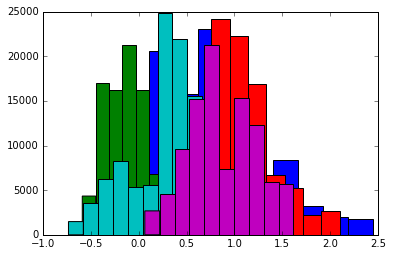

In [96]:
plt.hist(fd1.fithyper_chain_zb)
plt.hist(fd2.fithyper_chain_zb)
plt.hist(fd3.fithyper_chain_zb)
plt.hist(fd4.fithyper_chain_zb)
plt.hist(fd5.fithyper_chain_zb)


(array([  5972.,  18844.,  21372.,  16670.,   6129.,   6660.,   7016.,
          6613.,   8308.,   2416.]),
 array([ 0.18969658,  0.38489645,  0.58009633,  0.77529621,  0.97049608,
         1.16569596,  1.36089583,  1.55609571,  1.75129558,  1.94649546,
         2.14169533]),
 <a list of 10 Patch objects>)

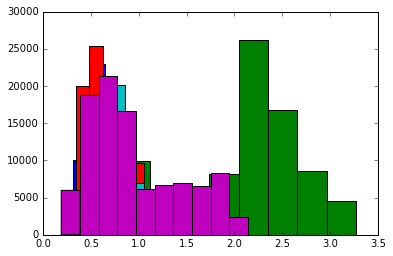

In [97]:
plt.hist(fd1.fithyper_chain_sp)
plt.hist(fd2.fithyper_chain_sp)
plt.hist(fd3.fithyper_chain_sp)
plt.hist(fd4.fithyper_chain_sp)
plt.hist(fd5.fithyper_chain_sp)

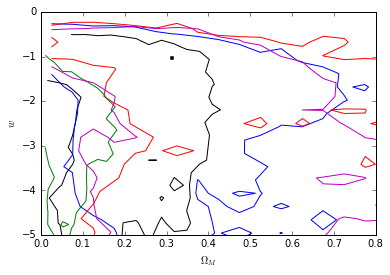

In [98]:
datas={'0':fd1,'1':fd2,'2':fd3,'3':fd4,'4':fd5}
nb=20
cor=['k','b','r','g','m']
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].fithyper_chain_o_m,datas[str(i)].fithyper_chain_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains_fithyper.png')
plt.show()

## Do the numerical marginalization 

Use the likelihood:
\begin{equation}
\log L=-\frac{1}{2} \sum_i \left(\frac{(z_{\rm Obs,i}-z_i)^2}{\sigma_z^2}+\frac{(\mu_{\rm Obs,i}-\mu(z_i,\Omega_m,H_0,w))^2}{\sigma_{\mu}^2} + \frac{(z_i-\bar z)^2}{\sigma_p^2} \right) + constants
\end{equation}

And we fit for $\vartheta=\Omega_m,H_0,w,z_i$.


In [56]:
def log_like_nummarg(data,om,H0,w,zs):
    mu_t=mu(zs,om,H0,w)
    return -0.5*(((data.z-zs)/(0.01*(1+data.z)))**2+((data.mu_o-mu_t)/0.01)**2+\
                 ((zs-0.5)/0.1)**2)

def MCMC_SNe_nmarg(N,data):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    log_like=np.zeros(N)
    
    nzs=len(data.z)
    zs=np.zeros((N,nzs))
    
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    zs[0,:]=data.z+np.random.randn(nzs)*0.05
    log_like[0]=sum(log_like_nummarg(data,o_m[0],H0[0],w[0],zs[0,:]))
    
    #dummy var for acceptance rate
    accept=1
    for i in range(N-1):
        accept+=1
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        zs[i+1,:]=zs[i,:]+np.random.randn(nzs)*0.05
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            zs[i+1,:]=zs[i,:]
            
            log_like[i+1]=log_like[i]
            accept-=1
            continue
        else:
            #compute new log_like
            log_like[i+1]=sum(log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:]))
            #if priors not flat they need to be included after the exp. for now flat prior
            r=sp.exp(log_like[i+1]-log_like[i])
            #accept or not
            teste=np.random.rand()
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                zs[i+1,:]=zs[i,:]
                log_like[i+1]=log_like[i]
                accept-=1
                continue
            
                
        #really cool piece of code from Ethan
        inc100 = np.int64(i/(N)*100)
        inc50 = np.int64(i/(N)*50)
        sys.stdout.write('\r')
        sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
        sys.stdout.flush()
    
    acceptr=accept/N*100
    data.nmarg_acceptr=acceptr
    data.nmarg_chain_o_m=o_m
    data.nmarg_chain_w=w
    data.nmarg_chain_H0=H0
    data.nmarg_chain_zs=zs
    data.nmarg_log_like=log_like
    

In [57]:
MCMC_SNe_nmarg(Nsteps,fd1)

[################                                  ]33%

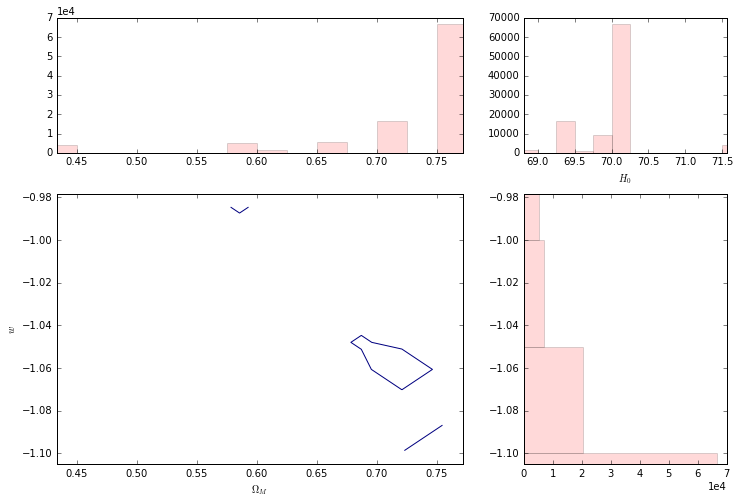

In [58]:
plot_contour_hist_1(fd1,loglike='num_marg')

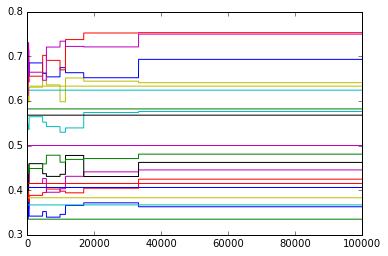

In [59]:
for i in range(10):
    plt.plot(fd1.nmarg_chain_zs[:,i])
    plt.plot(fd1.z_real[i]*np.ones(Nsteps))
    

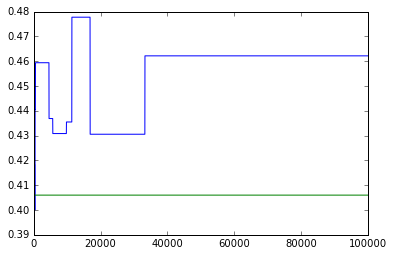

In [60]:
plt.plot(fd1.nmarg_chain_zs[:,3])
plt.plot(fd1.z_real[3]*np.ones(Nsteps))

In [61]:
fd1.z_real[3]

0.40600000000000003